# PDAC Calibration - 5y probability changes

Author: Sophie Wagner, sw3767@cumc.columbia.edu

In [30]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from tqdm import tqdm
from datetime import datetime
import random 

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof

# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Set up matrix

In [37]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]):  # Loop over each age layer
        layer = matrix[age_layer]
        for row_idx in range(layer.shape[0]):  # Loop over each row
            row = layer[row_idx]
            
            # Exclude diagonal (stay-in-state) and ACM (all-cause mortality) from scaling
            acm_idx = -1  # Assuming ACM is the last state (adjust index if necessary)
            non_diag_sum = np.sum(row) - row[row_idx] - row[8] - row[7] # Exclude diagonal and ACM and CSD
            
            if non_diag_sum > 1:  # If the non-ACM probabilities exceed 1
                scaling_factor = 1 / non_diag_sum
                row[:-2] *= scaling_factor  # Scale all except the last column (ACM)
            
            # Adjust diagonal (stay-in-state probability)
            row[row_idx] = max(0, 1 - non_diag_sum - row[8] - row[7])
    
    return matrix


def create_matrix():
    matrix = np.zeros((len(c.age_layers_5y), len(c.health_states_itos), len(c.health_states_itos)))
    matrix[:, 0, 1] = 1-(1-0.0011)**(1/25) # average risk after 50 ~ 0.0011, transformed to annual prob
    matrix[:, 1, 2] = c.model_inputs_dict['p_Local_to_Regional_PC']  
    matrix[:, 2, 3] = c.model_inputs_dict['p_Regional_to_Distant_PC']
    matrix[:, 1, 4] = c.model_inputs_dict['p_symptom_local'] 
    matrix[:, 2, 5] = c.model_inputs_dict['p_symptom_regional']
    matrix[:, 3, 6] = c.model_inputs_dict['p_symptom_distant']
    
    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):
    matrix = np.clip(matrix, 0.00000001, 1.0)
    matrix[:, 0, 1] = np.maximum.accumulate(matrix[:, 0, 1])
    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2])
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3])
    matrix[:, 2, 5] = np.maximum(matrix[:, 1, 4], matrix[:, 2, 5])
    matrix[:, 3, 6] = np.maximum(matrix[:, 2, 5], matrix[:, 3, 6])
    
    return matrix


def add_acm(matrix):
    if matrix.shape[0] == 65:
        matrix[:, :7, 8] = c.acm_1y[:65, np.newaxis]  # 1y ACM
    else:
        matrix[:, :7, 8] = c.acm_5y[:, np.newaxis]  # 5y ACM
    matrix[:, 8, 8] = 1
    return matrix


def add_csd(matrix):  # Constant death rate in calibration
    matrix[:, 4, 7] = int(c.model_inputs_dict['p_local_death'])
    matrix[:, 5, 7] = int(c.model_inputs_dict['p_regional_death'])
    matrix[:, 6, 7] = int(c.model_inputs_dict['p_distant_death'])
    matrix[:, 7, 7] = 1
    return matrix

## Markov model

In [38]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (13, 9, 9)
    inflow_matrix = np.tril(matrixT, k=-1)
    
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        mat, inflow_mat = matrixT[age_layer], inflow_matrix[age_layer] 
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        if current_age in c.ages_5y:
            age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    return incidence, prevalence, incidence_unadj, pop_log

## Calibration

In [39]:
def step(matrix, step_size, num_adj=3):
    points = list(c.transitions_itos.keys()) 
    step_tp = random.choices(points, k=num_adj)
    step_age = random.choices(c.age_layers_5y, k=num_adj)
    new_matrix = matrix.copy()
    for i in range(num_adj):
        (from_state, to_state), age = step_tp[i], step_age[i]
        step_param = new_matrix[age, from_state, to_state] * step_size
        new_matrix[age, from_state, to_state] += np.random.uniform(low=-step_param, high=step_param)
    
    new_matrix[11, :, :] = np.minimum(new_matrix[10, :, :], new_matrix[11, :, :])
    new_matrix[12, :, :] = np.minimum(new_matrix[11, :, :], new_matrix[12, :, :])
    new_matrix = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], new_matrix, axis=0, smooth=0.001)([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5])
    assert new_matrix.shape[0]==13
    
    new_matrix = constrain_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = row_normalize(new_matrix)

    return new_matrix

In [40]:
def simulated_annealing(n_iterations, step_size, n_adj=5, starting_temp = 1, start_tmat=None, verbose=False, print_interval=1000):

    if start_tmat is None:
        start_tmat = create_matrix()

    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = gof.objective(best_log)  # evaluate the initial point
    curr_t, curr_eval = best_t, best_eval  # current working solution
    ticker = 0

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        
        for i in range(n_iterations):

            # Run model
            candidate_t = np.copy(curr_t)
            candidate_t = step(candidate_t, step_size, n_adj)
            candidate_log = run_markov(candidate_t)
            candidate_eval = gof.objective(candidate_log)  # Evaluate candidate point

            # Update "best" if better than candidate
            if candidate_eval < best_eval:
                ticker = 0
                best_t, best_eval = np.copy(candidate_t), np.copy(candidate_eval)
                best_log = run_markov(best_t)

            else:
                ticker += 1

            t = starting_temp / (1 + 0.1 * np.log(i + 1))  # Slower cooling

            # Progress report
            if verbose and i>0 and i % print_interval == 0:
                log_adj, _, inc_log, _ = best_log
                total_dxd = np.sum(inc_log[4:7, :]) / c.N
                print(i, ": ", best_eval, "   PDAC: ", round(total_dxd, 5),"   tick:",ticker)
                if i % 50000 == 0:
                    transition_probs = p.extract_transition_probs(best_t, metric="avg")
                    print(f"Progress report, i = {i}")
                    print(transition_probs)
                    p.plot_vs_seer(log_adj, c.seer_inc)

            # Check if we should update "curr"
            diff = (candidate_eval - curr_eval)  # difference between candidate and current point evaluation
            metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
            if (diff < 0 or np.random.random() < metropolis):  # check if we should keep the new point
                curr_t, curr_eval = np.copy(candidate_t), np.copy(candidate_eval)  # store the new current point
                ticker = 0

            pbar.update(1)

    print(best_eval)
    
    return best_t

## Run 

In [35]:
def run_sa(tmat=None, save_all=False, n_iterations=50000, step_size=0.2, n_adj=5, start_tmat=None, starting_temp=None, print_interval=10000):
    start_tmat = None
    if tmat is not None:
        start_tmat = tmat
    else:
        start_tmat = create_matrix()
        
    initial_score = gof.objective(run_markov(start_tmat))
    print(f"Initial score: {round(initial_score, 5)}")
    print("Starting calibration...")
    result = simulated_annealing(n_iterations=n_iterations, step_size=step_size, n_adj=n_adj, start_tmat=start_tmat, verbose=True, print_interval=print_interval)
    
    # Gather results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)
    final_score = gof.objective(curr_log)
    log_adj, log_prev, log_inc, pop_log = curr_log
    tps = p.extract_transition_probs(curr_tmat, "markov", metric="avg", save=save_all, timestamp=timestamp)
    
    # Saving
    if save_all:
        log_path, tmat_path, plot_path = c.OUTPUT_PATHS["logs"], c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)
        pd.DataFrame(log_adj).to_csv(f"{log_path}/{timestamp}_inc_adj.csv")
        pd.DataFrame(log_prev).to_csv(f"{log_path}/{timestamp}_prev.csv")
        pd.DataFrame(log_inc).to_csv(f"{log_path}/{timestamp}_inc_unadj.csv")
        pd.DataFrame(pop_log.T).to_csv(f"{log_path}/{timestamp}_pop_log.csv")
        p.plot_vs_seer(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer_total(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        
    else:
        print(tps)
        p.plot_vs_seer(log_adj, c.seer_inc, show_plot=True)
        p.plot_vs_seer_total(log_adj, c.seer_inc, show_plot=True)
        p.plot_params(curr_tmat,  show_plot=True)

    return curr_tmat

Initial score: 10248.45825
Starting calibration...


Simulated annealing progress: 100%|██████████| 200/200 [00:00<00:00, 268.66iteration/s]


9260.937022680602
   From State    To State  Probability
0     healthy  u_PDAC_loc     0.000062
1  u_PDAC_loc  u_PDAC_reg     0.556008
2  u_PDAC_reg  u_PDAC_dis     0.595910
3  u_PDAC_loc  d_PDAC_loc     0.074940
4  u_PDAC_reg  d_PDAC_reg     0.314611
5  u_PDAC_dis  d_PDAC_dis     0.468034


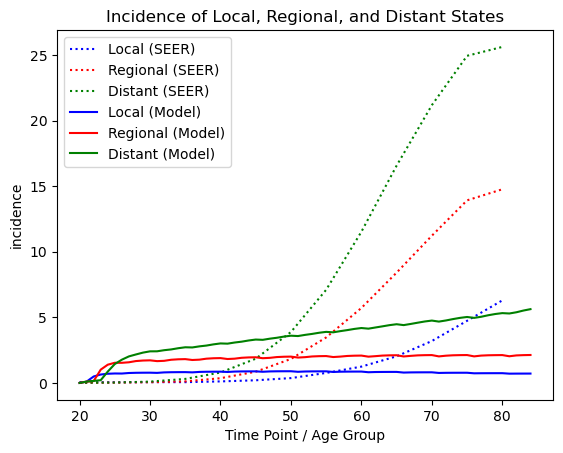

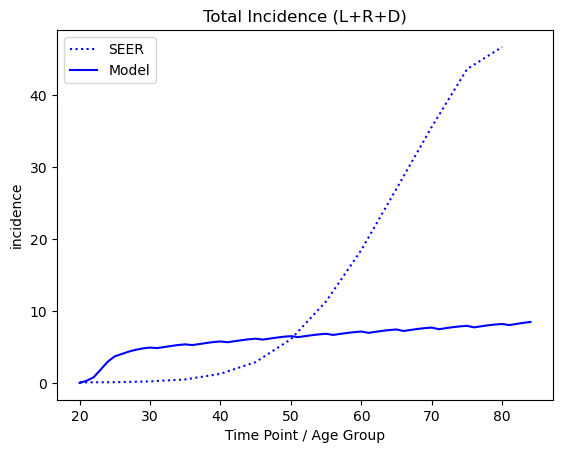

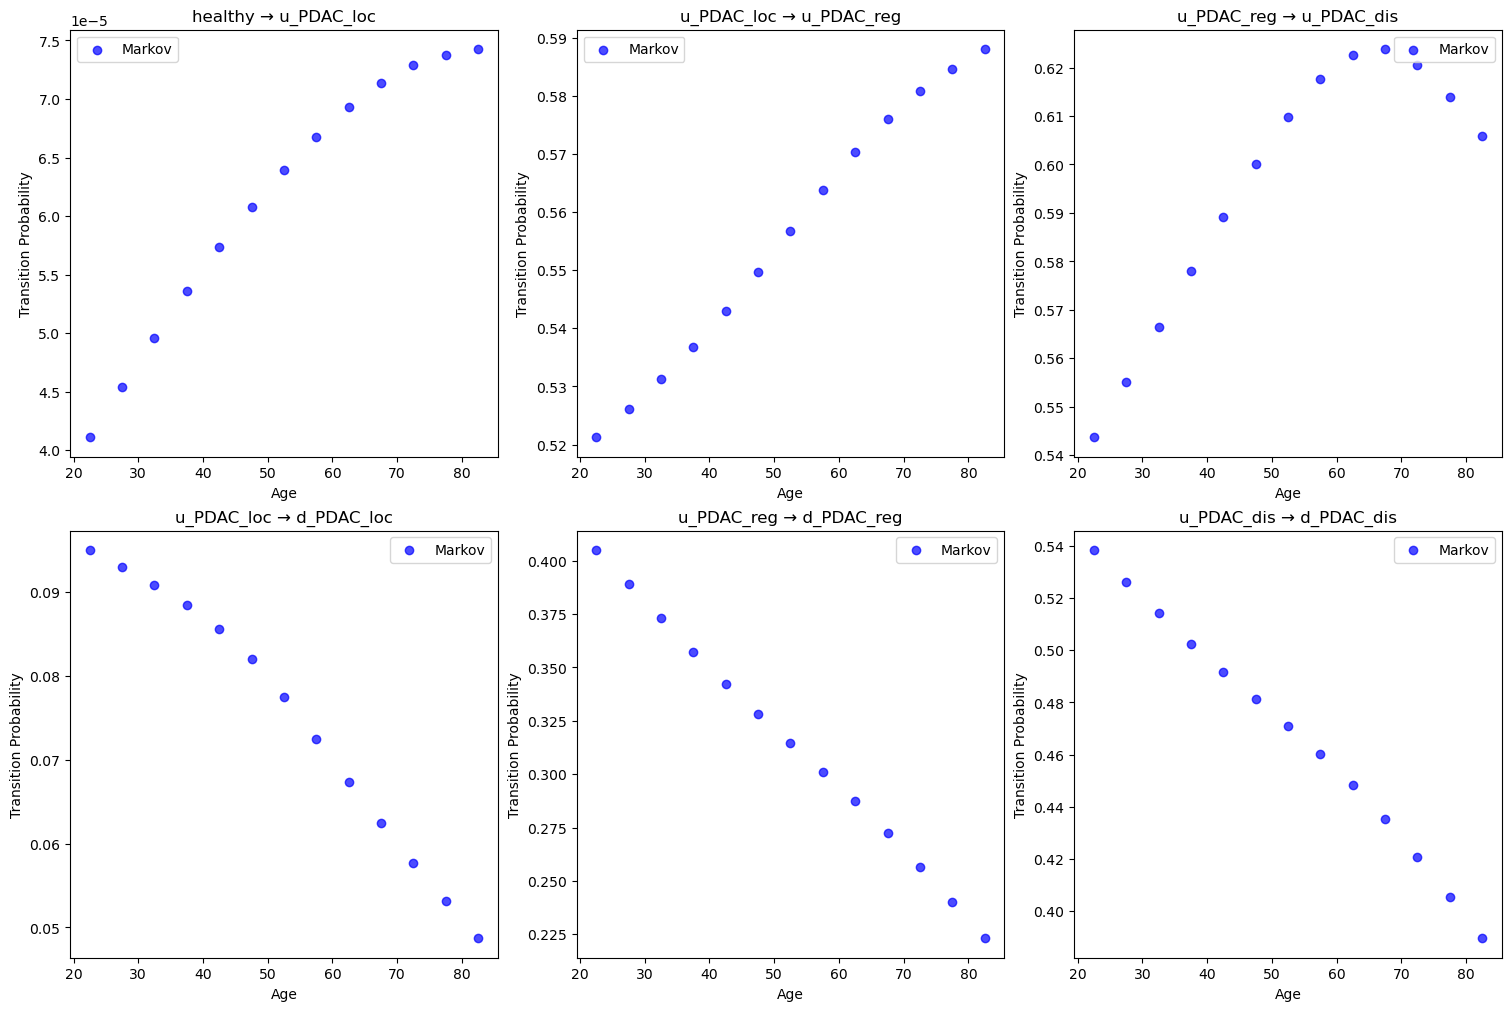

In [36]:
result = run_sa(tmat=None, save_all=False, n_iterations=200, step_size=0.2, n_adj=5, start_tmat=None, starting_temp=50)

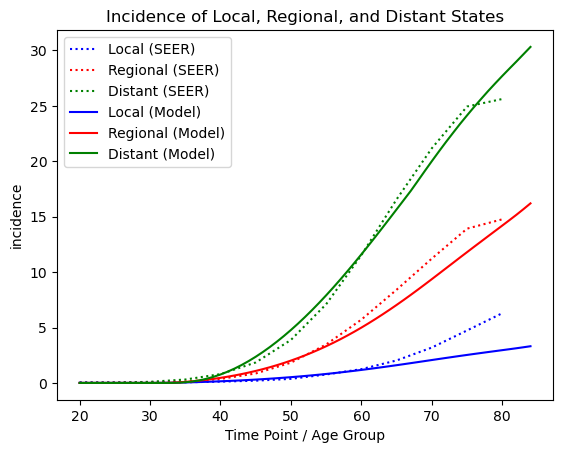

In [75]:
temp = result.copy()
temp[:,0,1]*=1.1
log = run_markov(temp)
p.plot_vs_seer(log[0], c.seer_inc)

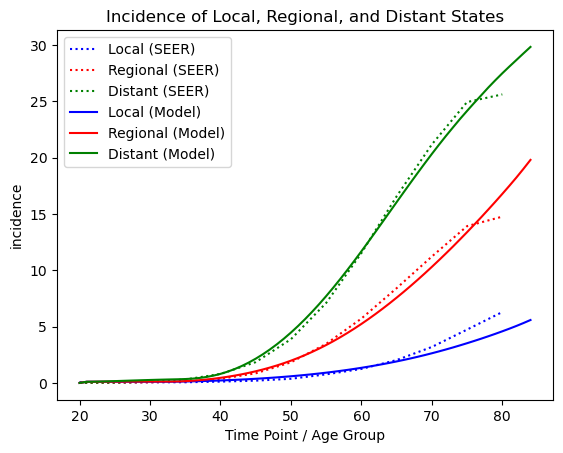

In [140]:
# result_next.shape
# small_tmat = result_next[::5,:,:]
# tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], small_tmat, axis=0, smooth=0.001)(c.ages_1y)
# tmat_smoothed = add_acm(tmat_smoothed)
# tmat_smoothed = add_csd(tmat_smoothed)
# tmat_smoothed = constrain_matrix(tmat_smoothed)
# tmat_smoothed = row_normalize(tmat_smoothed)
# result_next_next = run_sa(tmat_smoothed)
# temp = result_next_next.copy()
# temp[:30, 0, 1] = np.maximum(temp[:30, 0, 1], 0.000001)
# temp[30:50,0,1]*=1.3
# temp[50:, 0, 1] = 1.5*temp[50,0,1]
# temp[:20,1,2]*=0.9
# temp[:20,2,3]*=0.9
# temp[30:,1,2]=min(result_next_next[:,1,2])
# temp[30:,2,3]=min(result_next_next[:,2,3])
# temp[50:,1,2]=min(result_next_next[:,1,2])*0.8
# temp[50:,2,3]=min(result_next_next[:,2,3])*0.8
# temp[50:,1,4]*=1.2
# temp = temp[::5,:,:]
# tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], temp, axis=0, smooth=0.001)(c.ages_1y)
# tmat_smoothed = add_acm(tmat_smoothed)
# tmat_smoothed = add_csd(tmat_smoothed)
# tmat_smoothed = constrain_matrix(tmat_smoothed)
# tmat_smoothed = row_normalize(tmat_smoothed)
# log = run_markov(tmat_smoothed)
# p.plot_vs_seer(log[0], c.seer_inc)

### Post-processing

In [ ]:
import os
def smooth_tmat(mat, save=False, outpath=c.OUTPUT_PATHS['tmats'], timestamp=""): # (sex: 2, race: 2, age_buckets: 10, state: 18, state: 18)
    
    # Anchor with mean at 100 and Smooth interpolation over age
    tmat_anchored = np.concatenate([mat, np.minimum(mat[-1:, :, :], np.mean(mat, axis=0, keepdims=True))], axis=2) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)
    tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], mat, smooth=0.01, axis=0)(np.linspace(20,100,81)) # interpolation without anchoring
    tmat_anchored = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], tmat_anchored, smooth=0.01, axis=2)(np.linspace(18,100,83)).clip(0.0, 1.0)

    # If smoothed tmat is exp increasing towards end, used anchored probs
    increasing_at_100 = tmat[-2:-1, :, :] < tmat[-1:, :, :]
    tmat_anchored = np.where(increasing_at_100, tmat_anchored, tmat)
    transition_mask = np.zeros((13, 13), dtype=bool)
    from_states, to_states= c.transitions_itos.keys()
    transition_mask[from_states, to_states] = True
    tmat_anchored = np.where(increasing_at_100 & transition_mask[np.newaxis, ...], tmat_anchored, tmat)

    tmat = tmat_anchored
    tmat = row_normalize(tmat)

    if save:
      os.makedirs(outpath, exist_ok=True)
      name = f"tmat_{timestamp}"
      np.save(f"{outpath}/{name}.npy", tmat)
      
    return tmat

In [ ]:
markov_tmat = result
treeage_tmat = smooth_tmat(markov_tmat, save=True, timestamp=timestamp, name="Microsim")
p.plot_params(markov_tmat, treeage_tmat, save=save_calibration_results, folder=folder, name="microsim_parameters")